In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [375]:

OUT_DIR = "4Top_results_jan102"
PLOT_DIR = f"{OUT_DIR}/plots"
LOG_DIR  = f"{OUT_DIR}/hyperedge_logs"
CKPT_DIR = f"{OUT_DIR}/checkpoints"
epoch = 24

In [376]:
combined_df = pd.read_pickle(
    f"{OUT_DIR}/MASTER_combined_epoch_{epoch}.pkl"
)


In [377]:
combined_df.head()
combined_df.columns
combined_df.shape


(4000, 18)

In [378]:
import numpy as np

combined_df["case"] = np.select(
    [
        (combined_df.true_label == 1) & (combined_df.pred_label == 1),
        (combined_df.true_label == 0) & (combined_df.pred_label == 0),
        (combined_df.true_label == 0) & (combined_df.pred_label == 1),
        (combined_df.true_label == 1) & (combined_df.pred_label == 0),
    ],
    ["TP", "TN", "FP", "FN"],
    default="UNDEF"
)


In [379]:
combined_df.case.value_counts()


case
TN    1965
TP    1443
FN     513
FP      79
Name: count, dtype: int64

In [380]:
idx_max = combined_df.groupby("event_id")["hyperedge_score"].idxmax()
event_max = combined_df.loc[idx_max].reset_index(drop=True)


In [381]:
event_max.event_id.nunique(), len(event_max)


(3223, 3223)

In [382]:
idx_min = combined_df.groupby("event_id")["hyperedge_score"].idxmin()
event_min = combined_df.loc[idx_min].reset_index(drop=True)
event_min.event_id.nunique(), len(event_min)


(3223, 3223)

In [383]:
event_max[["event_id", "hyperedge_score", "case"]].head()
event_min[["event_id", "hyperedge_score", "case"]].head()


,event_id,hyperedge_score,case
0,0,0.004880,FN
1,1,0.014454,FN
2,3,0.145033,TP
3,4,0.005293,TN
4,5,0.753309,TP


In [384]:
# remove non-physical geometry
event_max = event_max[(event_max.mean_dr > 0) & (~event_max.mean_dr.isna())]
event_min = event_min[(event_min.mean_dr > 0) & (~event_min.mean_dr.isna())]


In [385]:
event_max.mean_dr.min(), event_min.mean_dr.min()


(1.133637619912565, 1.1399959654851246)

In [386]:
len(event_max), len(event_min)


(3223, 3223)

In [387]:
n_removed_min = combined_df.groupby("event_id")["mean_dr"].min().eq(0).sum()
n_removed_max = combined_df.groupby("event_id")["mean_dr"].max().eq(0).sum()

n_removed_min, n_removed_max


(0, 0)

In [388]:
# events whose min hyperedge is degenerate
bad_min_events = combined_df.groupby("event_id")["mean_dr"].min().eq(0).sum()

# events whose max hyperedge is degenerate
bad_max_events = combined_df.groupby("event_id")["mean_dr"].max().eq(0).sum()

bad_min_events, bad_max_events


(0, 0)

In [389]:
import numpy as np

def add_jet_pt_features(df):
    df = df.copy()
    df["jet_pt_min"]  = df.jet_pts.apply(np.min)
    df["jet_pt_max"]  = df.jet_pts.apply(np.max)
    df["jet_pt_mean"] = df.jet_pts.apply(np.mean)
    df["jet_pt_std"]  = df.jet_pts.apply(np.std)
    df["n_jets_evt"]  = df.jet_pts.apply(len)
    return df


In [390]:
event_max = add_jet_pt_features(event_max)
event_min = add_jet_pt_features(event_min)


In [391]:
event_max[
    ["jet_pt_min", "jet_pt_max", "jet_pt_mean", "jet_pt_std", "n_jets_evt"]
].head()


,jet_pt_min,jet_pt_max,jet_pt_mean,jet_pt_std,n_jets_evt
0,27.454952,431.318665,127.196474,138.581223,6
1,43.737030,246.441452,150.667453,83.073615,5
2,75.704582,855.683777,392.370954,330.321857,6
3,26.375385,178.222565,74.413733,53.776238,6
4,24.689436,131.223724,80.556034,34.317330,6


In [392]:
event_max[["jet_pt_min", "jet_pt_max", "jet_pt_mean"]].describe()


,jet_pt_min,jet_pt_max,jet_pt_mean
count,3223.000000,3223.000000,3223.000000
mean,33.115003,200.697952,93.714049
std,14.646635,120.505787,41.784106
min,21.653297,38.024616,32.032562
25%,24.629341,123.787941,66.918845
50%,28.468695,167.404190,83.259924
75%,36.065460,238.327049,107.758965
max,187.656570,1325.443237,541.640249


In [393]:
event_max["geom_x_pt"] = event_max.mean_dr * event_max.jet_pt_mean
event_min["geom_x_pt"] = event_min.mean_dr * event_min.jet_pt_mean


In [394]:
event_max[["mean_dr", "jet_pt_mean", "geom_x_pt"]].head()
event_min[["mean_dr", "jet_pt_mean", "geom_x_pt"]].head()


,mean_dr,jet_pt_mean,geom_x_pt
0,2.338030,127.196474,297.389122
1,1.743551,150.667453,262.696453
2,3.496751,392.370954,1372.023716
3,2.566582,74.413733,190.988931
4,3.137034,80.556034,252.707057


In [395]:
event_max.geom_x_pt.describe()
event_min.geom_x_pt.describe()


count    3223.000000
mean      227.302918
std       106.722943
min        53.177569
25%       156.303959
50%       202.114896
75%       266.817218
max      1372.023716
Name: geom_x_pt, dtype: float64

In [396]:
LOW_CUT  = 0.2
HIGH_CUT = 0.8

# model strongly believes
event_max_high = event_max[event_max.hyperedge_score > HIGH_CUT]

# model strongly rejects
event_min_low  = event_min[event_min.hyperedge_score < LOW_CUT]


In [397]:
event_max_high.hyperedge_score.min(), event_max_high.hyperedge_score.max()


(0.8000178337097168, 1.0)

In [398]:
event_min_low.hyperedge_score.min(), event_min_low.hyperedge_score.max()

(0.003025453770533204, 0.1950518786907196)

In [399]:
event_max_high_TP = event_max_high[event_max_high.case == "TP"]
event_max_high_TN = event_max_high[event_max_high.case == "TN"]
event_max_high_FP = event_max_high[event_max_high.case == "FP"]
event_max_high_FN = event_max_high[event_max_high.case == "FN"]


In [400]:
event_min_low_TP = event_min_low[event_min_low.case == "TP"]
event_min_low_TN = event_min_low[event_min_low.case == "TN"]
event_min_low_FP = event_min_low[event_min_low.case == "FP"]
event_min_low_FN = event_min_low[event_min_low.case == "FN"]


In [401]:
{
    "high_TP": len(event_max_high_TP),
    "high_TN": len(event_max_high_TN),
    "high_FP": len(event_max_high_FP),
    "high_FN": len(event_max_high_FN),
    "low_TP":  len(event_min_low_TP),
    "low_TN":  len(event_min_low_TN),
    "low_FP":  len(event_min_low_FP),
    "low_FN":  len(event_min_low_FN),
}


{'high_TP': 373,
 'high_TN': 107,
 'high_FP': 2,
 'high_FN': 0,
 'low_TP': 307,
 'low_TN': 1578,
 'low_FP': 19,
 'low_FN': 403}

In [402]:
TP = event_max_high_TP
FP = event_max_high_FP
TN = event_min_low_TN
FN = event_min_low_FN



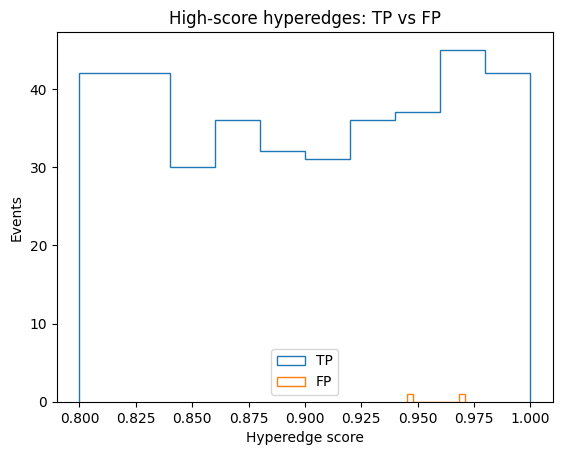

In [403]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(TP.hyperedge_score, bins=10, histtype="step", label="TP")
plt.hist(FP.hyperedge_score, bins=10, histtype="step", label="FP")
plt.xlabel("Hyperedge score")
plt.ylabel("Events")
plt.legend()
plt.title("High-score hyperedges: TP vs FP")
plt.show()


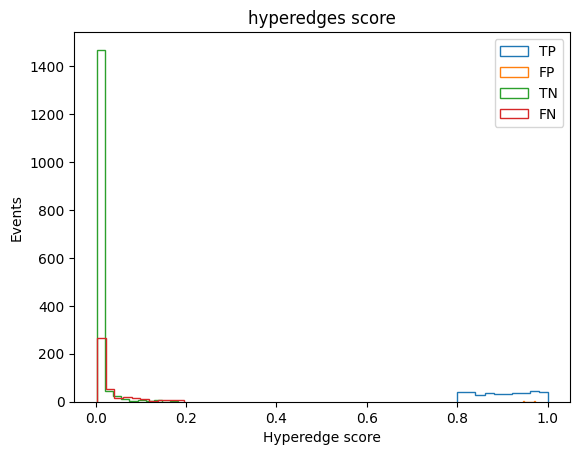

In [404]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(TP.hyperedge_score, bins=10, histtype="step", label="TP")
plt.hist(FP.hyperedge_score, bins=10, histtype="step", label="FP")
plt.hist(TN.hyperedge_score, bins=10, histtype="step", label="TN")
plt.hist(FN.hyperedge_score, bins=10, histtype="step", label="FN")
plt.xlabel("Hyperedge score")
plt.ylabel("Events")
plt.legend()
plt.title("hyperedges score")
plt.show()


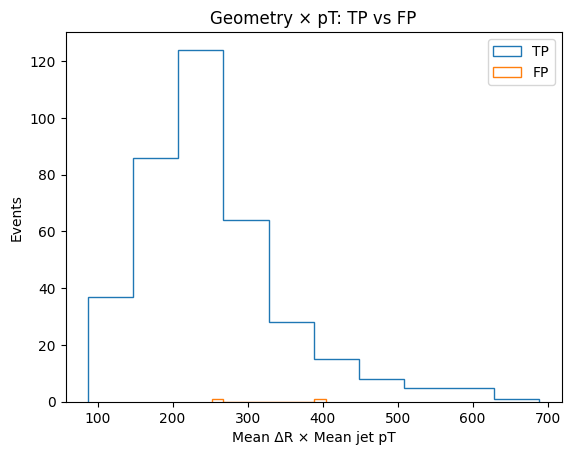

In [405]:
plt.figure()
plt.hist(TP.geom_x_pt, bins=10, histtype="step", label="TP")
plt.hist(FP.geom_x_pt, bins=10, histtype="step", label="FP")
plt.xlabel("Mean ΔR × Mean jet pT")
plt.ylabel("Events")
plt.legend()
plt.title("Geometry × pT: TP vs FP")
plt.show()


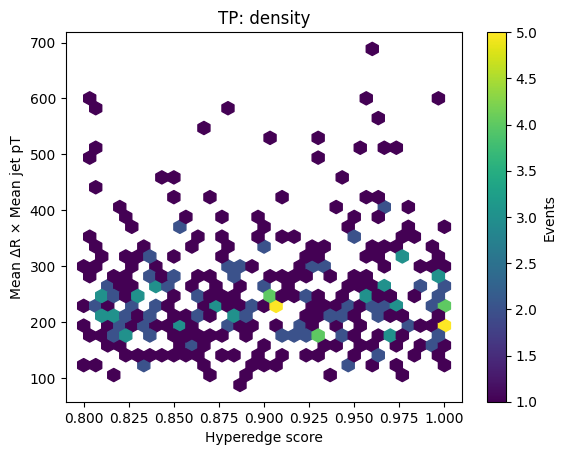

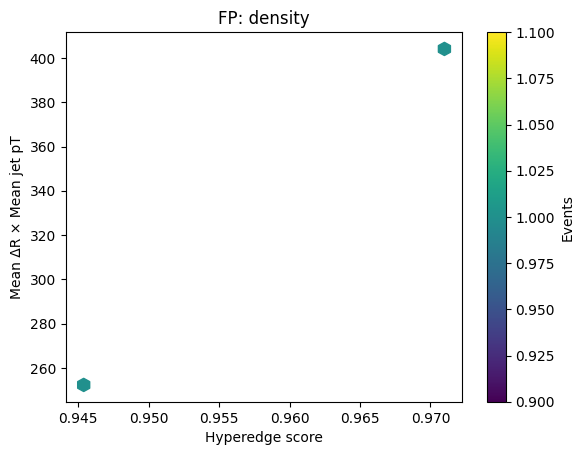

In [406]:
plt.figure()
plt.hexbin(
    TP.hyperedge_score,
    TP.geom_x_pt,
    gridsize=30,
    mincnt=1
)
plt.xlabel("Hyperedge score")
plt.ylabel("Mean ΔR × Mean jet pT")
plt.title("TP: density")
plt.colorbar(label="Events")
plt.show()

plt.figure()
plt.hexbin(
    FP.hyperedge_score,
    FP.geom_x_pt,
    gridsize=30,
    mincnt=1
)
plt.xlabel("Hyperedge score")
plt.ylabel("Mean ΔR × Mean jet pT")
plt.title("FP: density")
plt.colorbar(label="Events")
plt.show()


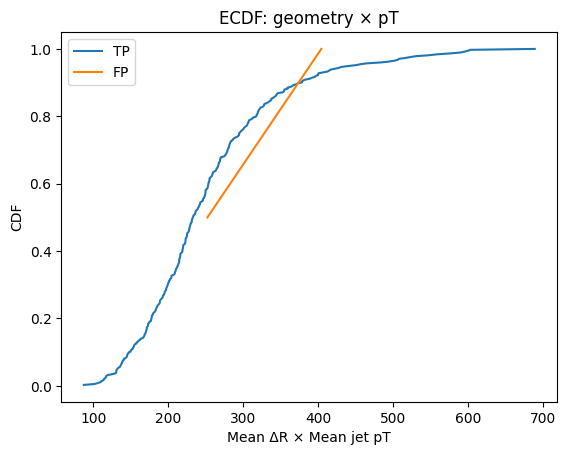

In [407]:
def ecdf(x):
    x = np.sort(x)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

plt.figure()
x, y = ecdf(TP.geom_x_pt)
plt.plot(x, y, label="TP")
x, y = ecdf(FP.geom_x_pt)
plt.plot(x, y, label="FP")
plt.xlabel("Mean ΔR × Mean jet pT")
plt.ylabel("CDF")
plt.legend()
plt.title("ECDF: geometry × pT")
plt.show()


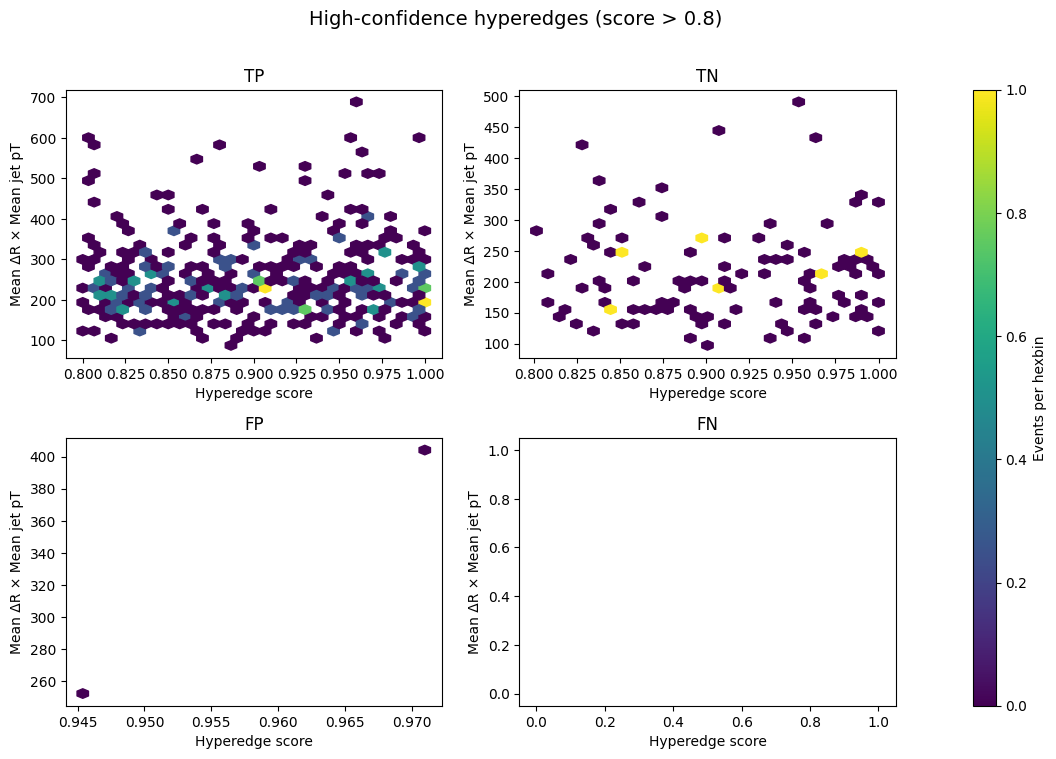

In [408]:
import matplotlib.pyplot as plt

dfs = {
    "TP": event_max_high_TP,
    "TN": event_max_high_TN,
    "FP": event_max_high_FP,
    "FN": event_max_high_FN,
}

fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 0.06])

axes = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[1, 1]),
]

cax = fig.add_subplot(gs[:, 2])  # dedicated colorbar axis

hb = None
for ax, (label, df) in zip(axes, dfs.items()):
    hb = ax.hexbin(
        df.hyperedge_score.values,
        df.geom_x_pt.values,
        gridsize=30,
        mincnt=1
    )
    ax.set_title(label)
    ax.set_xlabel("Hyperedge score")
    ax.set_ylabel("Mean ΔR × Mean jet pT")

cb = fig.colorbar(hb, cax=cax)
cb.set_label("Events per hexbin")

fig.suptitle("High-confidence hyperedges (score > 0.8)", fontsize=14)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

plt.show()


In [409]:
dfs_low = {
    "TP": event_min_low_TP,
    "TN": event_min_low_TN,
    "FP": event_min_low_FP,
    "FN": event_min_low_FN,
}
for k, v in dfs_low.items():
    print(k, len(v))


TP 307
TN 1578
FP 19
FN 403


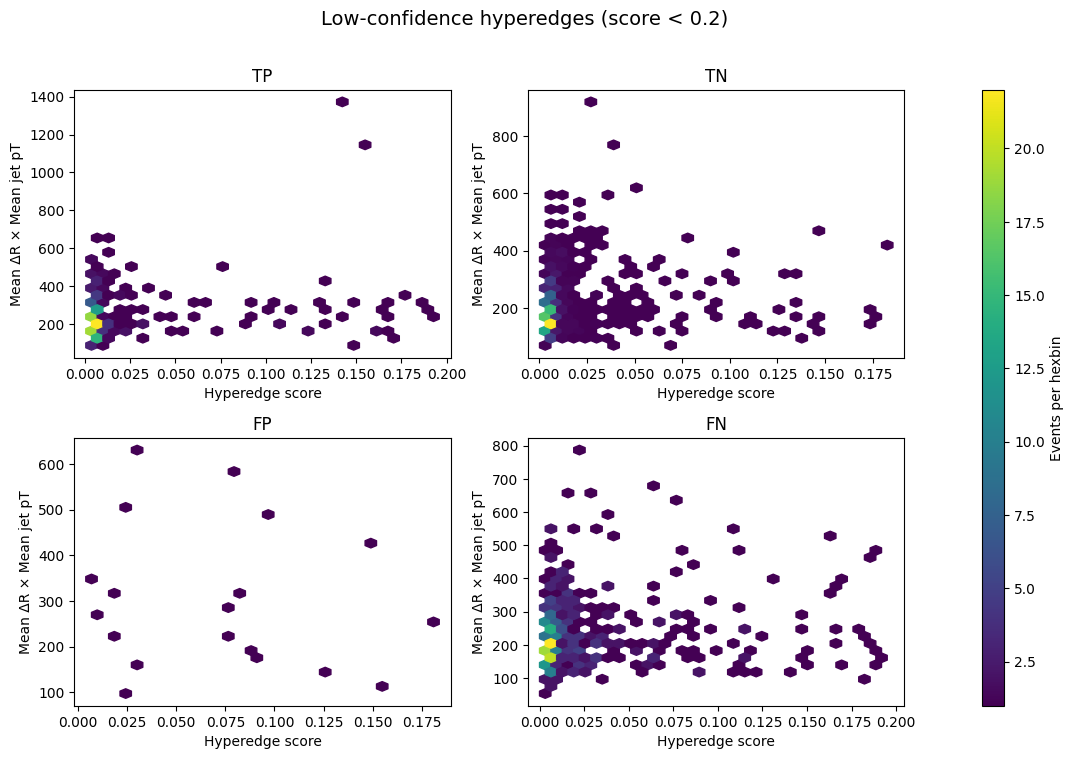

In [410]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 0.06])

axes = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[1, 1]),
]

cax = fig.add_subplot(gs[:, 2])  # colorbar axis

hb = None
for ax, (label, df) in zip(axes, dfs_low.items()):
    hb = ax.hexbin(
        df.hyperedge_score.values,
        df.geom_x_pt.values,
        gridsize=30,
        mincnt=1
    )
    ax.set_title(label)
    ax.set_xlabel("Hyperedge score")
    ax.set_ylabel("Mean ΔR × Mean jet pT")

cb = fig.colorbar(hb, cax=cax)
cb.set_label("Events per hexbin")

fig.suptitle("Low-confidence hyperedges (score < 0.2)", fontsize=14)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

plt.show()


In [411]:
import matplotlib.pyplot as plt

def plot_all_hexbin_explainability(
    df_high,
    df_low,
    gridsize=30,
    save=False,
    outdir="."
):
    """
    Generate 8 hexbin figures:
      - 4 features × (high-score, low-score)
      - 4 subplots per figure (TP/TN/FP/FN)

    Parameters
    ----------
    df_high : DataFrame
        event-level data with hyperedge_score > 0.8
    df_low : DataFrame
        event-level data with hyperedge_score < 0.2
    gridsize : int
        Hexbin resolution
    save : bool
        Save figures if True
    outdir : str
        Output directory if save=True
    """

    features = {
        "min ΔR": ("mean_dr", "Min ΔR"),
        "max ΔR": ("max_dr", "Max ΔR"),
        "min jet pT": ("jet_pt_min", "Min jet pT [GeV]"),
        "max jet pT": ("jet_pt_max", "Max jet pT [GeV]"),
    }

    cases = ["TP", "TN", "FP", "FN"]

    for label, df in [
        ("High confidence (score > 0.8)", df_high),
        ("Low confidence (score < 0.2)", df_low),
    ]:
        for feat_name, (col, ylab) in features.items():

            fig = plt.figure(figsize=(12, 8))
            gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 0.06])

            axes = [
                fig.add_subplot(gs[0, 0]),
                fig.add_subplot(gs[0, 1]),
                fig.add_subplot(gs[1, 0]),
                fig.add_subplot(gs[1, 1]),
            ]

            cax = fig.add_subplot(gs[:, 2])
            hb = None

            for ax, case in zip(axes, cases):
                sub = df[df.case == case]

                if len(sub) == 0:
                    ax.set_title(f"{case} (empty)")
                    ax.axis("off")
                    continue

                hb = ax.hexbin(
                    sub.hyperedge_score.values,
                    sub[col].values,
                    gridsize=gridsize,
                    mincnt=1
                )

                ax.set_title(case)
                ax.set_xlabel("Hyperedge score")
                ax.set_ylabel(ylab)

            if hb is not None:
                cb = fig.colorbar(hb, cax=cax)
                cb.set_label("Events per hexbin")

            fig.suptitle(f"{feat_name} vs Hyperedge score\n{label}", fontsize=14)
            fig.subplots_adjust(wspace=0.3, hspace=0.3)

            if save:
                fname = (
                    f"{outdir}/hexbin_{feat_name.replace(' ', '_')}_"
                    f"{label.replace(' ', '_')}.png"
                )
                plt.savefig(fname, dpi=150)

            plt.show()


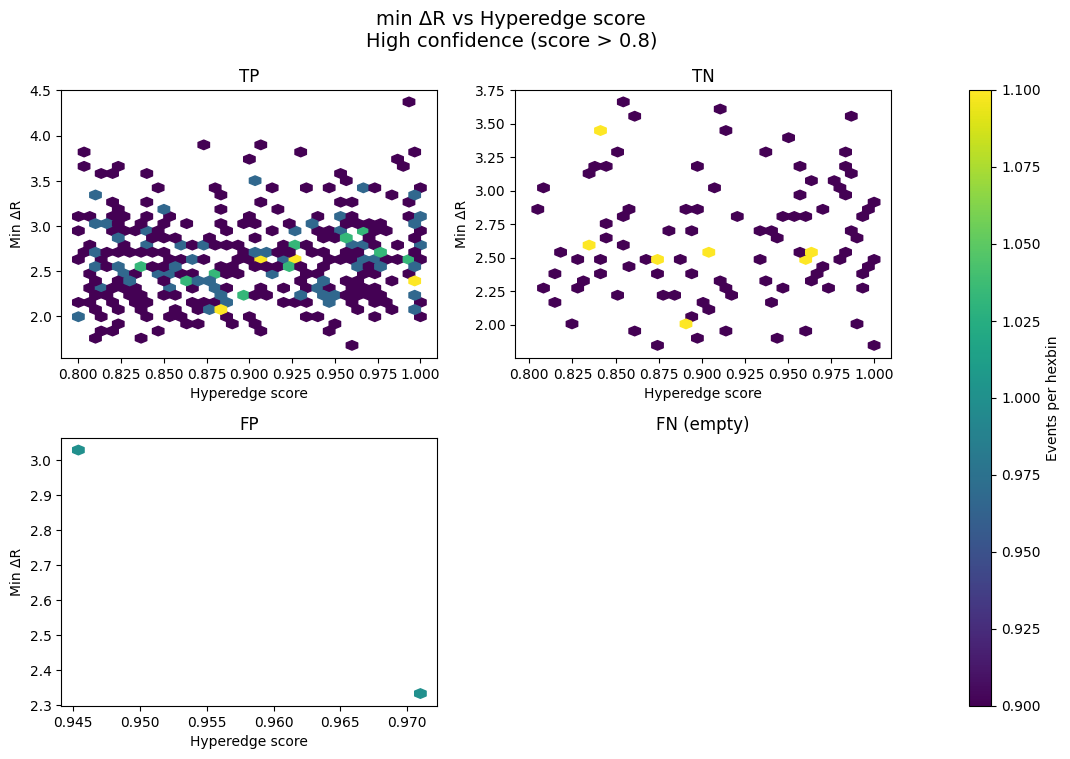

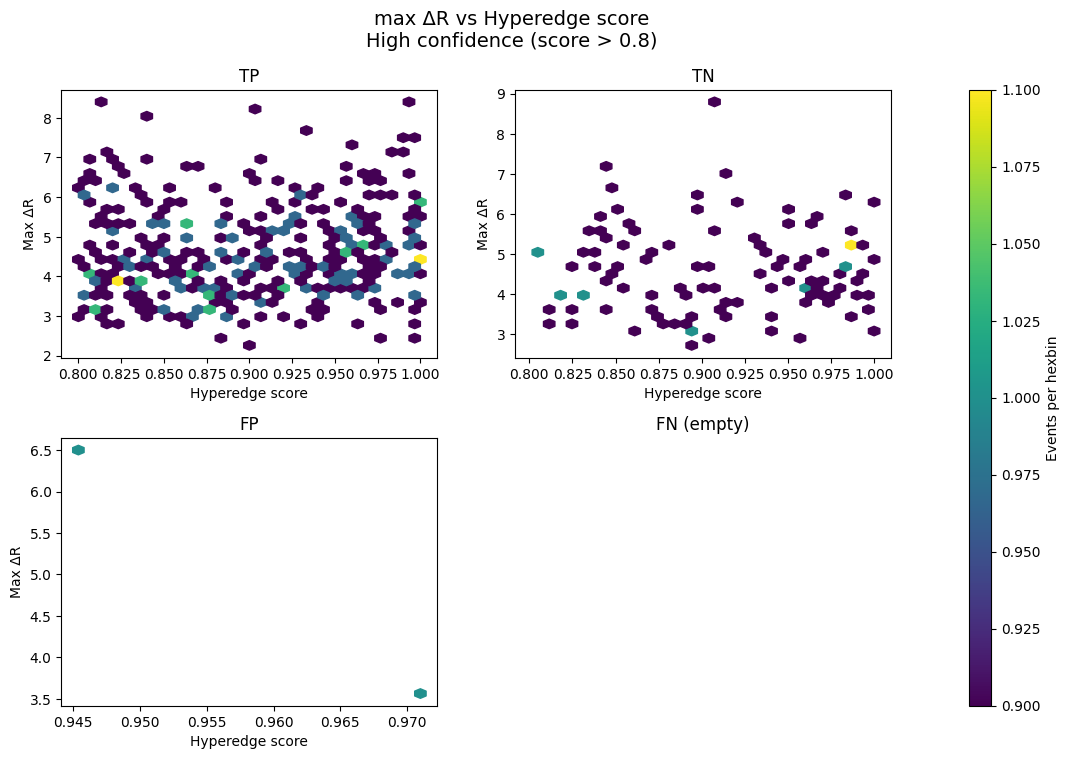

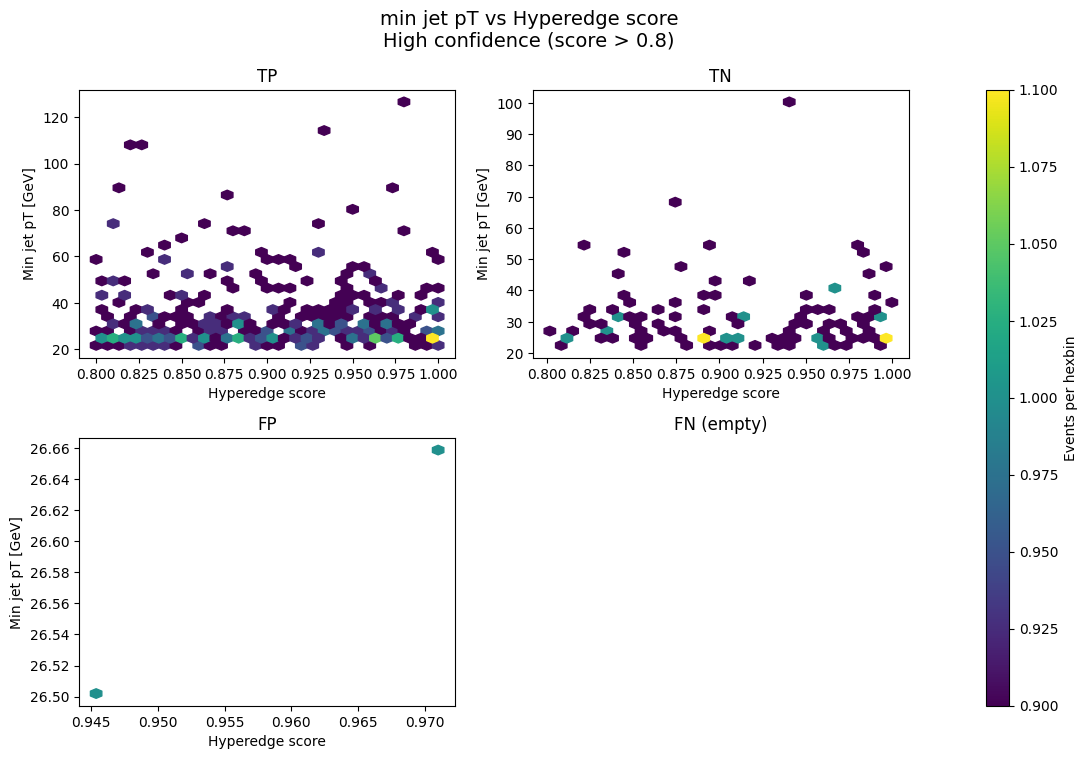

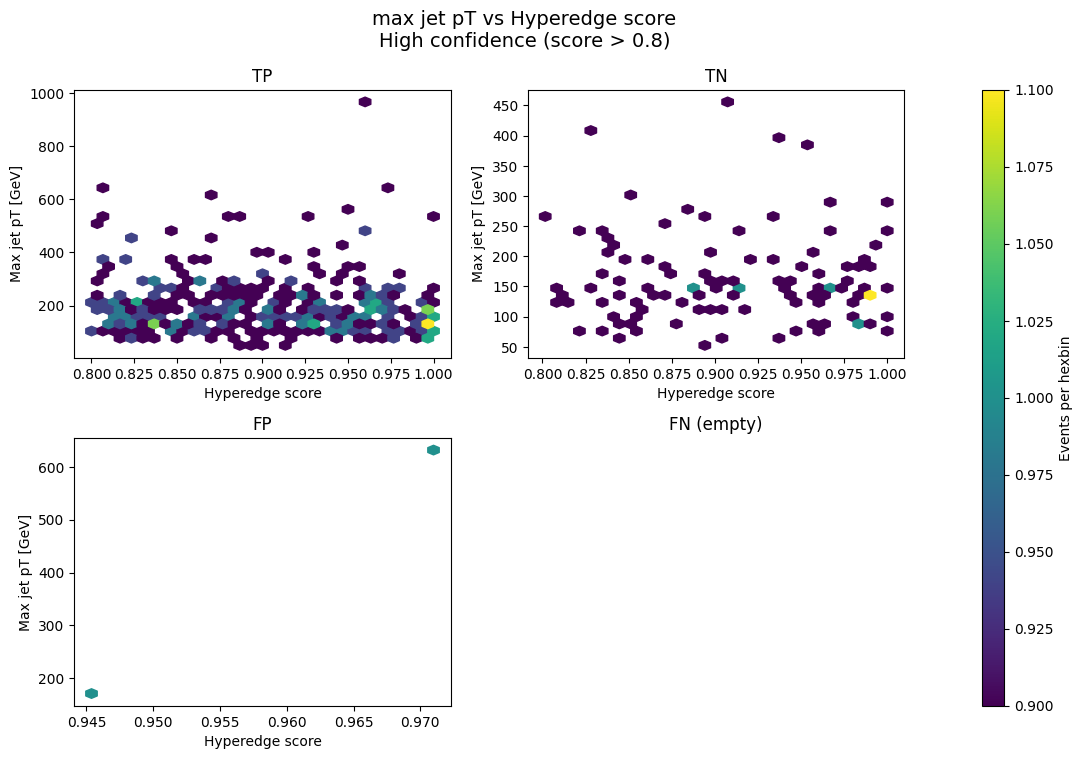

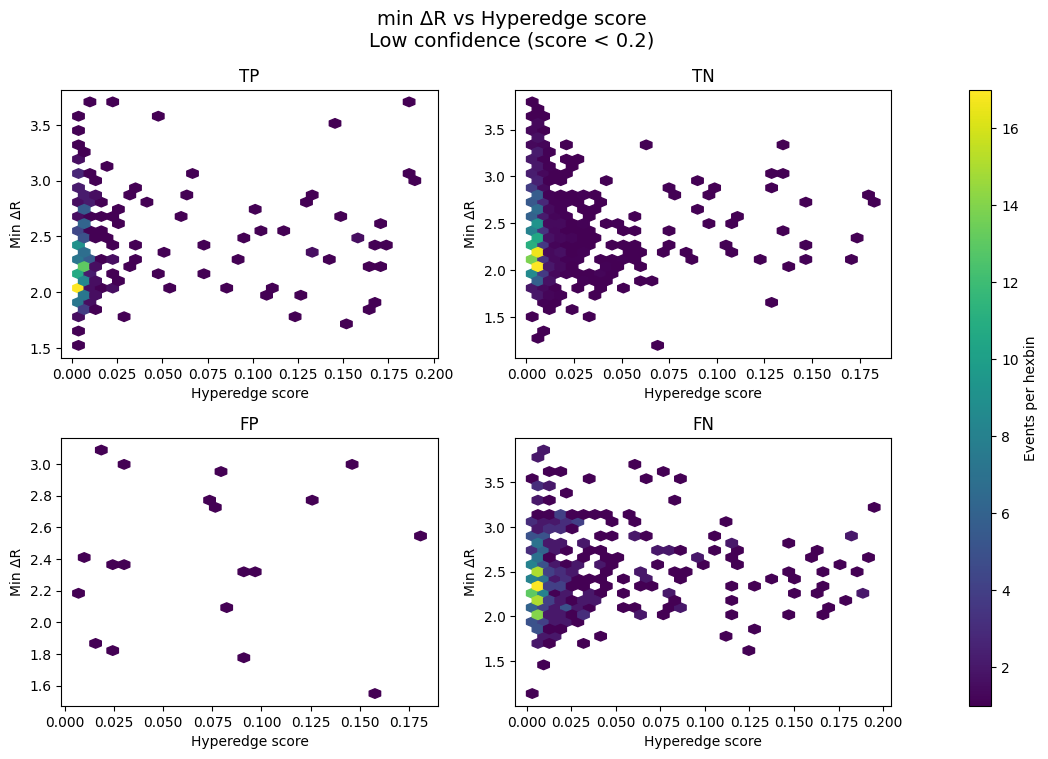

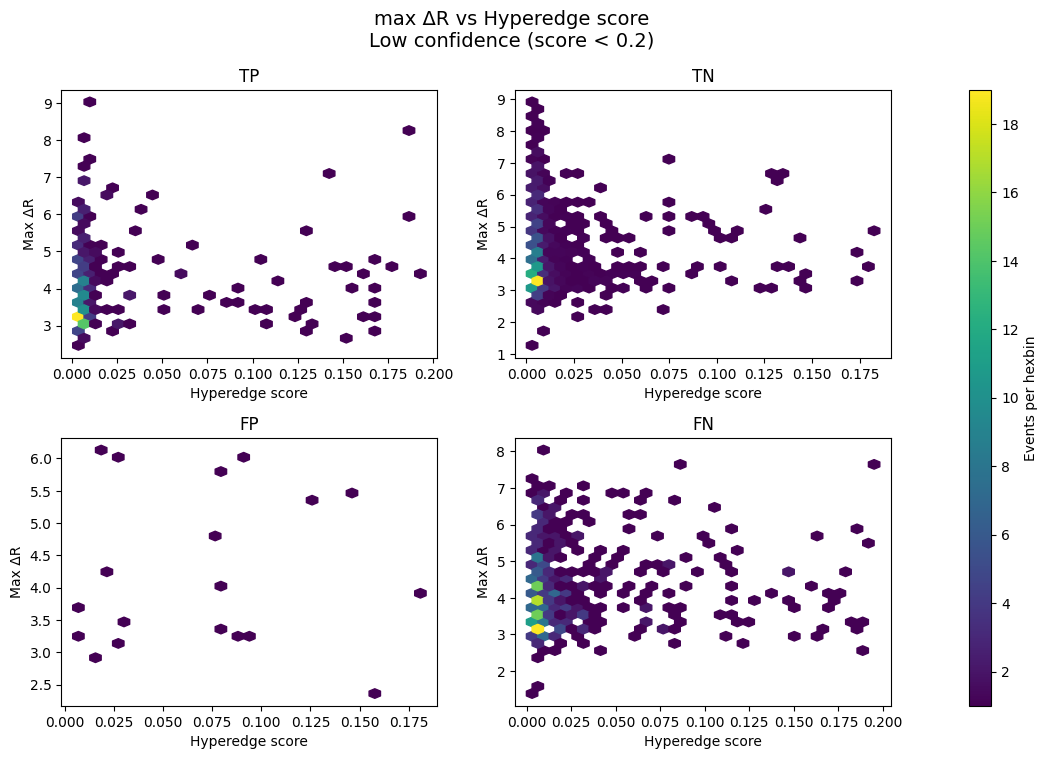

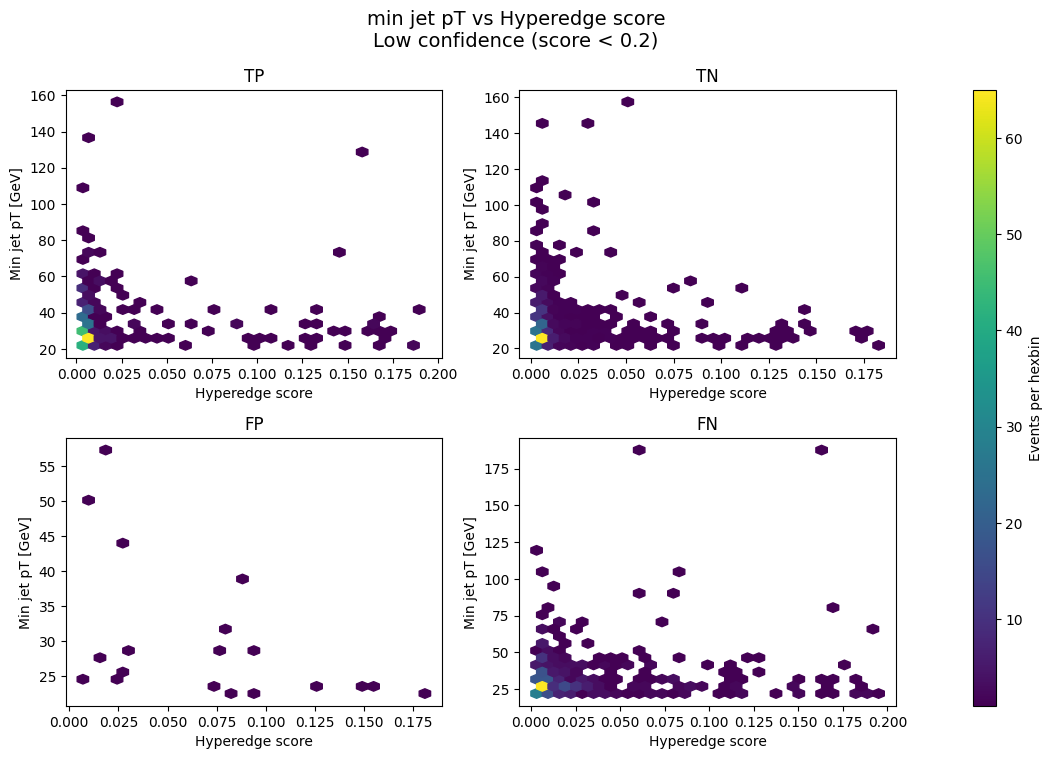

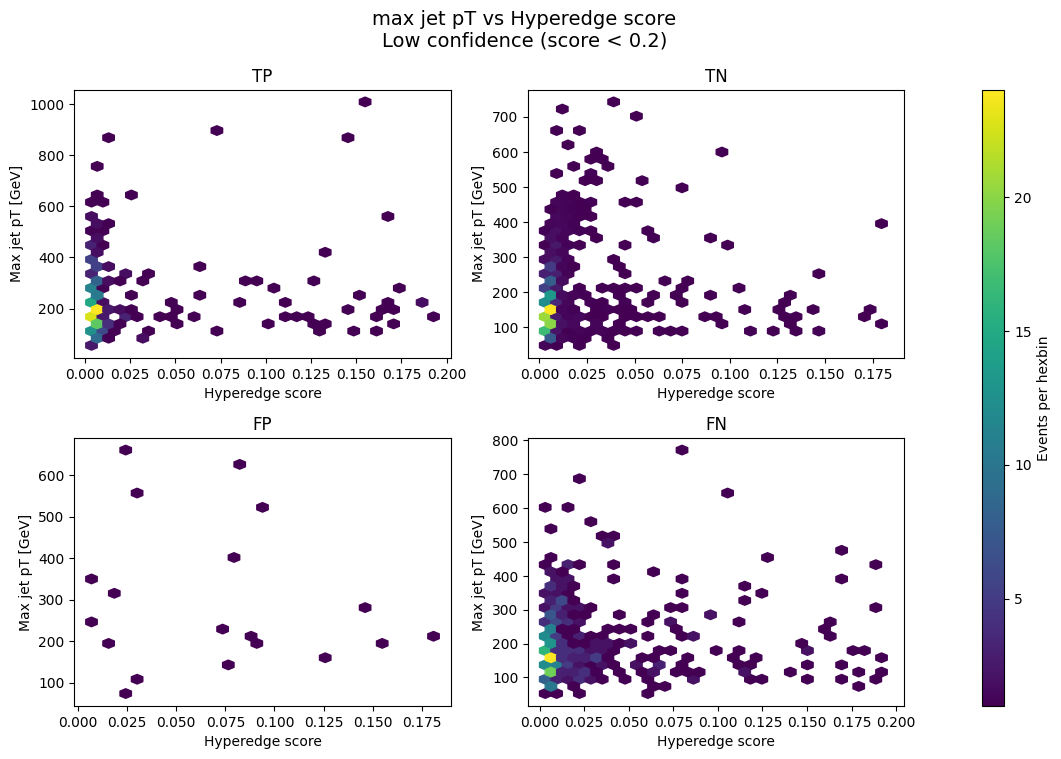

In [412]:
plot_all_hexbin_explainability(
    df_high=event_max_high,
    df_low=event_min_low,
    gridsize=30,
    save=False  # change to True if you want files
)


In [413]:
TP_evt = event_max[event_max.case == "TP"]
TN_evt = event_max[event_max.case == "TN"]
FP_evt = event_max[event_max.case == "FP"]
FN_evt = event_max[event_max.case == "FN"]
len(TP_evt), len(TN_evt), len(FP_evt), len(FN_evt)


(1154, 1584, 68, 417)

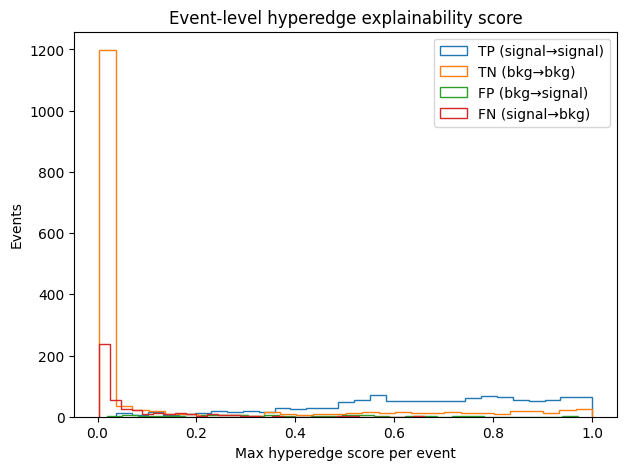

In [414]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.hist(TP_evt.hyperedge_score, bins=30, histtype="step", label="TP (signal→signal)")
plt.hist(TN_evt.hyperedge_score, bins=30, histtype="step", label="TN (bkg→bkg)")
plt.hist(FP_evt.hyperedge_score, bins=30, histtype="step", label="FP (bkg→signal)")
plt.hist(FN_evt.hyperedge_score, bins=30, histtype="step", label="FN (signal→bkg)")

plt.xlabel("Max hyperedge score per event")
plt.ylabel("Events")
plt.legend()
plt.title("Event-level hyperedge explainability score")
plt.show()


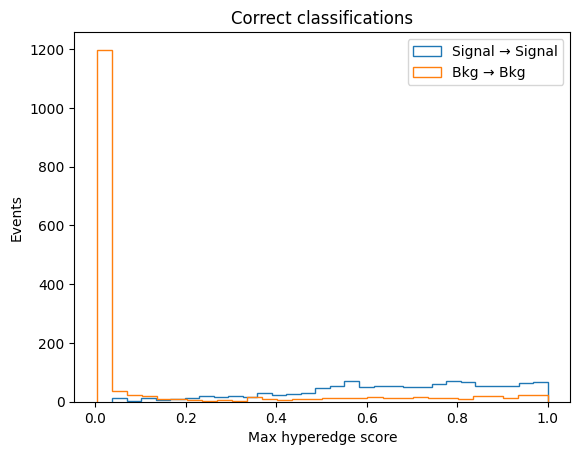

In [415]:
plt.figure()
plt.hist(TP_evt.hyperedge_score, bins=30, histtype="step", label="Signal → Signal")
plt.hist(TN_evt.hyperedge_score, bins=30, histtype="step", label="Bkg → Bkg")
plt.xlabel("Max hyperedge score")
plt.ylabel("Events")
plt.legend()
plt.title("Correct classifications")
plt.show()


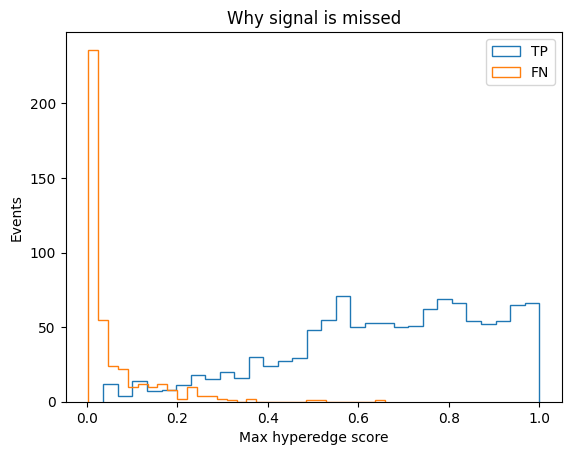

In [416]:
plt.figure()
plt.hist(TP_evt.hyperedge_score, bins=30, histtype="step", label="TP")
plt.hist(FN_evt.hyperedge_score, bins=30, histtype="step", label="FN")
plt.xlabel("Max hyperedge score")
plt.ylabel("Events")
plt.legend()
plt.title("Why signal is missed")
plt.show()


In [417]:
import numpy as np

def summary(name, df):
    return {
        "sample": name,
        "N": len(df),
        "median_score": np.median(df.hyperedge_score),
        "mean_score": np.mean(df.hyperedge_score),
        "IQR": np.percentile(df.hyperedge_score, 75) - np.percentile(df.hyperedge_score, 25),
    }

pd.DataFrame([
    summary("TP", TP_evt),
    summary("TN", TN_evt),
    summary("FP", FP_evt),
    summary("FN", FN_evt),
])


,sample,N,median_score,mean_score,IQR
0,TP,1154,0.687230,0.661761,0.317427
1,TN,1584,0.005829,0.136327,0.026458
2,FP,68,0.356840,0.384071,0.282764
3,FN,417,0.020705,0.055924,0.059207


In [418]:
df = event_max.copy()


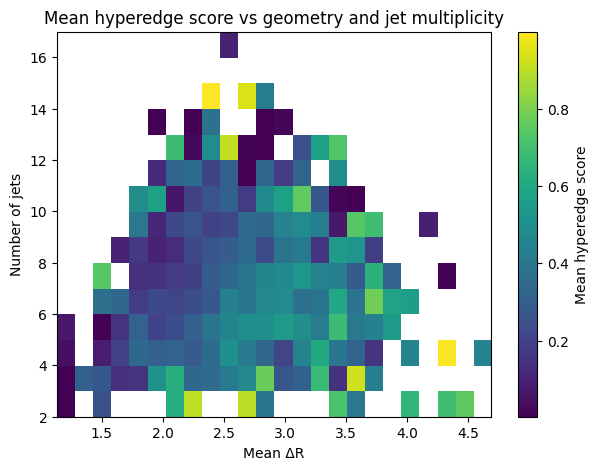

In [419]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d

# define bins
dr_bins = np.linspace(df.mean_dr.min(), df.mean_dr.max(), 25)
nj_bins = np.arange(df.n_jets_evt.min(), df.n_jets_evt.max() + 2)

# compute mean hyperedge score per bin
stat, xedges, yedges, _ = binned_statistic_2d(
    df.mean_dr,
    df.n_jets_evt,
    df.hyperedge_score,
    statistic="mean",
    bins=[dr_bins, nj_bins]
)

plt.figure(figsize=(7, 5))
plt.imshow(
    stat.T,
    origin="lower",
    aspect="auto",
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
)
plt.colorbar(label="Mean hyperedge score")
plt.xlabel("Mean ΔR")
plt.ylabel("Number of jets")
plt.title("Mean hyperedge score vs geometry and jet multiplicity")
plt.show()


In [420]:
high = df[df.hyperedge_score > 0.8]
mid  = df[(df.hyperedge_score >= 0.2) & (df.hyperedge_score <= 0.8)]
low  = df[df.hyperedge_score < 0.2]


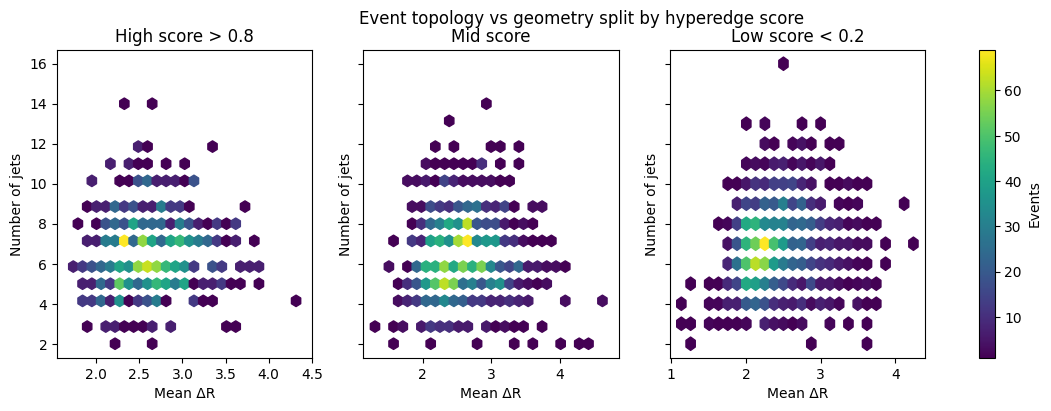

In [421]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

for ax, (label, sub) in zip(
    axes,
    [("High score > 0.8", high), ("Mid score", mid), ("Low score < 0.2", low)]
):
    hb = ax.hexbin(
        sub.mean_dr,
        sub.n_jets_evt,
        gridsize=25,
        mincnt=1
    )
    ax.set_title(label)
    ax.set_xlabel("Mean ΔR")
    ax.set_ylabel("Number of jets")

fig.colorbar(hb, ax=axes, label="Events")
plt.suptitle("Event topology vs geometry split by hyperedge score")
plt.show()


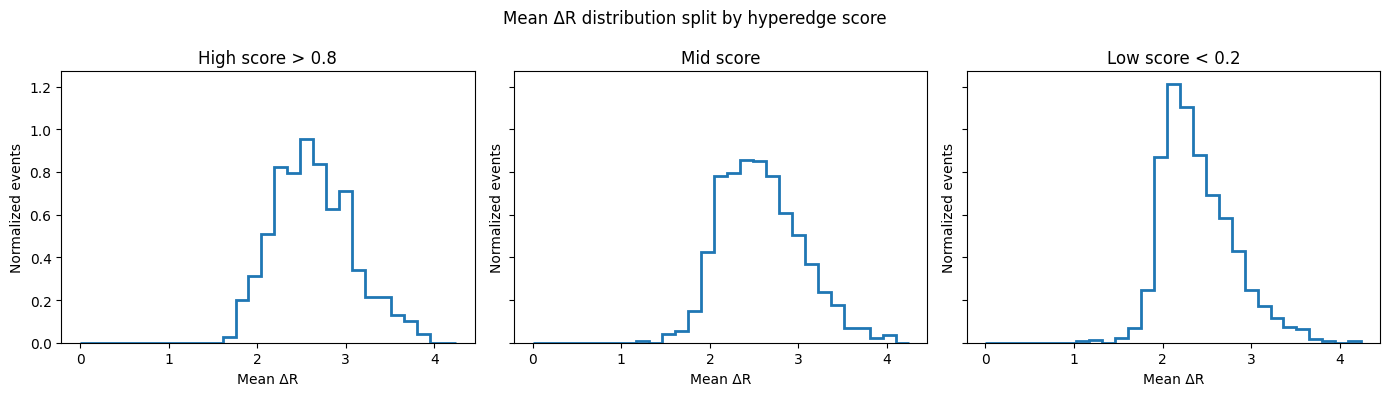

In [422]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

bins = np.linspace(0, sub.mean_dr.max(), 30)

for ax, (label, sub) in zip(
    axes,
    [("High score > 0.8", high),
     ("Mid score", mid),
     ("Low score < 0.2", low)]
):
    ax.hist(
        sub.mean_dr,
        bins=bins,
        histtype="step",
        linewidth=2,
        density=True
    )
    ax.set_title(label)
    ax.set_xlabel("Mean ΔR")
    ax.set_ylabel("Normalized events")

fig.suptitle("Mean ΔR distribution split by hyperedge score")
plt.tight_layout()
plt.show()


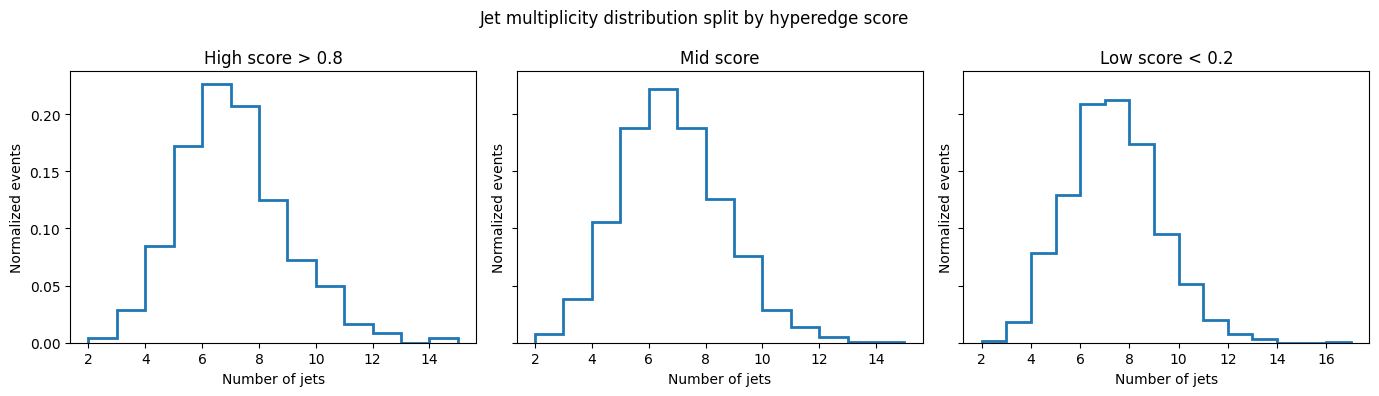

In [423]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

for ax, (label, sub) in zip(
    axes,
    [("High score > 0.8", high),
     ("Mid score", mid),
     ("Low score < 0.2", low)]
):
    ax.hist(
        sub.n_jets_evt,
        bins=np.arange(sub.n_jets_evt.min(), sub.n_jets_evt.max() + 2),
        histtype="step",
        linewidth=2,
        density=True
    )
    ax.set_title(label)
    ax.set_xlabel("Number of jets")
    ax.set_ylabel("Normalized events")

fig.suptitle("Jet multiplicity distribution split by hyperedge score")
plt.tight_layout()
plt.show()


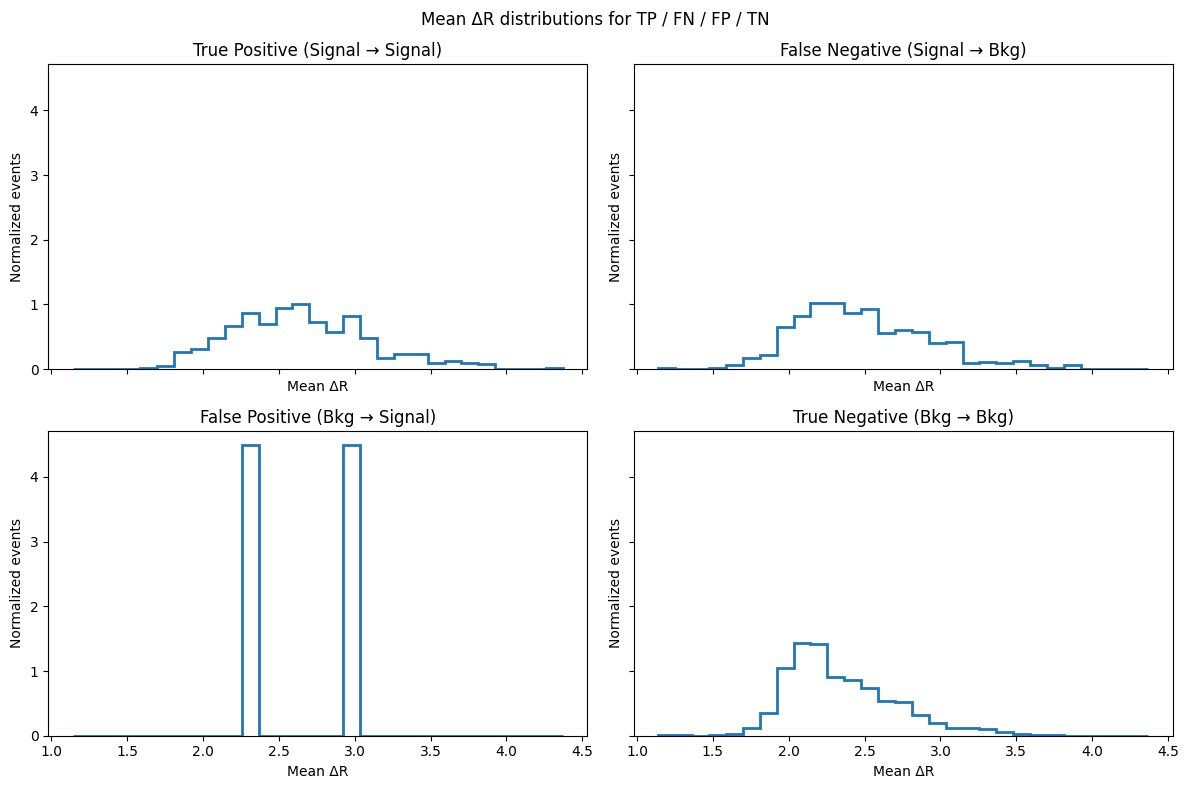

In [424]:
import numpy as np
import matplotlib.pyplot as plt

cases = [
    ("True Positive (Signal → Signal)", TP),
    ("False Negative (Signal → Bkg)", FN),
    ("False Positive (Bkg → Signal)", FP),
    ("True Negative (Bkg → Bkg)", TN),
]

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

# Common bins for fair comparison
all_dr = np.concatenate([c[1].mean_dr.values for c in cases])
bins = np.linspace(all_dr.min(), all_dr.max(), 30)

for ax, (label, df) in zip(axes, cases):
    ax.hist(
        df.mean_dr,
        bins=bins,
        histtype="step",
        linewidth=2,
        density=True
    )
    ax.set_title(label)
    ax.set_xlabel("Mean ΔR")
    ax.set_ylabel("Normalized events")

fig.suptitle("Mean ΔR distributions for TP / FN / FP / TN")
plt.tight_layout()
plt.show()


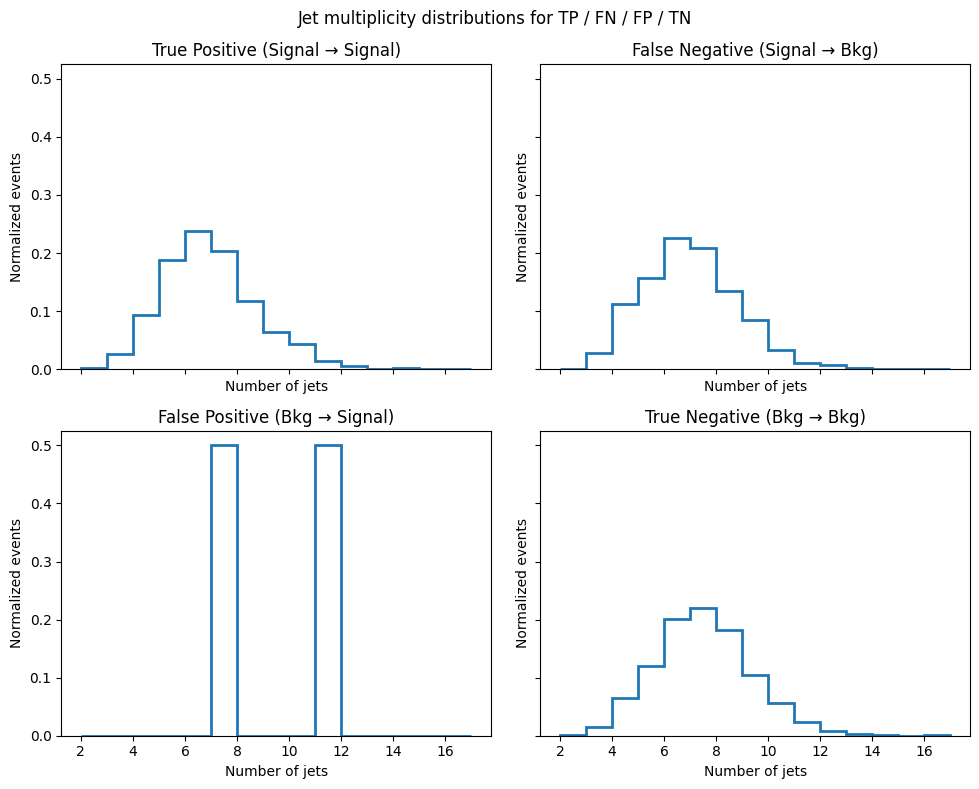

In [425]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.flatten()

# Common integer bins
all_njets = np.concatenate([c[1].n_jets_evt.values for c in cases])
bins = np.arange(all_njets.min(), all_njets.max() + 2)

for ax, (label, df) in zip(axes, cases):
    ax.hist(
        df.n_jets_evt,
        bins=bins,
        histtype="step",
        linewidth=2,
        density=True
    )
    ax.set_title(label)
    ax.set_xlabel("Number of jets")
    ax.set_ylabel("Normalized events")

fig.suptitle("Jet multiplicity distributions for TP / FN / FP / TN")
plt.tight_layout()
plt.show()
